In [1]:
###loading the task-fMRI data
from pathlib import Path
import glob
pathroot=Path('/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/')
subject = 'sub01'
modality = 'motor' #'rest'
postfix = '_ICA'
resolution = '' #'_3mm'
task_contrasts = {1: "foot",
                  2: "hand",
                  3: "tongue",
                  4: "foot_left",
                  5: "foot_right",
                  6: "hand_left",
                  7: "hand_right"}

pathdata = pathroot/subject/modality
print(pathdata)

task_activity_files = [];
for file in sorted(pathdata.glob('sess*/run*/zstats'+postfix+'_merged'+resolution+'.nii.gz')):
    task_activity_files.append(str(file))

brain_mask_files = [];
for file in sorted(pathdata.glob('sess*/run*/brain_mask.nii.gz')):
    brain_mask_files.append(str(file))

print(task_activity_files)
#print(brain_mask_files)
print(len(task_activity_files))

/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor
['/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess01/run1/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess01/run2/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess02/run1/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess02/run2/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess03/run1/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess03/run2/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess04/run1/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess04/run2/zstats_ICA_merged.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/pr

(7, 210)
20


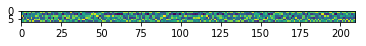

In [2]:
##loading actviation pattern for each region
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

##loading atlas region information
mist_atlas_file = "/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz"
df1=pd.read_csv("/data/cisl/raw_data/midnight/MIST_atlas/Parcel_Information/MIST_ROI.csv",
               sep=';', encoding="utf8",  error_bad_lines=False)
Region_ids = np.array(df1.roi)
Region_names = np.array(df1.name)

from nilearn.image import high_variance_confounds
from nilearn.input_data import NiftiMasker
from nilearn.input_data import NiftiLabelsMasker

###extract brain activity from task data
subjects_activity_matrix = [];
for activity_file,mask_file in zip(task_activity_files,brain_mask_files):
    #fmri_file = fmri_files[0]
    ##adjust group atlas to individual brain mask
    mist_atlas = NiftiLabelsMasker(labels_img=mist_atlas_file,
                                  detrend=True, standardize=True)
    mist_roi_act = mist_atlas.fit_transform(activity_file)
    subjects_activity_matrix.append(mist_roi_act)

plt.imshow(subjects_activity_matrix[0])
print(subjects_activity_matrix[0].shape)
print(len(subjects_activity_matrix))

In [3]:
###a simple classifier: X: activation within each region: feature: 210, samples: subjects*sessions*runs
###                     Y: type of movement: foot,hand,tongue

##feature matrix
Subjects = len(subjects_activity_matrix)
RegionsNum = 210

feature_matrix = []
task_labels = []
for subj in np.arange(Subjects):
    for taskid in np.arange(3):
        feature_matrix.append(subjects_activity_matrix[subj][taskid,])
        task_labels.append(task_contrasts[taskid+1])

print(np.array(feature_matrix).shape)
print(np.array(task_labels).shape)

X_data = np.vstack(feature_matrix)
Y_data = np.vstack(task_labels)
print(X_data.shape,Y_data.shape)

(60, 210)
(60,)
(60, 210) (60, 1)


In [75]:
def plot_roc_curve(X_train,Y_train_int,X_test,Y_test_int):
    ##roc curve
    from sklearn import preprocessing
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn import svm,metrics
    
    n_classes = len(np.unique(Y_train_int))
    Y_train_mat = preprocessing.label_binarize(Y_train_int, classes=np.unique(Y_train_int))
    Y_test_mat = preprocessing.label_binarize(Y_test_int, classes=np.unique(Y_train_int))
    
    clf = OneVsRestClassifier(svm.SVC(kernel='linear',decision_function_shape='ovr'))
    y_score = clf.fit(X_train, Y_train_mat).decision_function(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y_test_mat[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    lw = 2
    '''
    task_select = 0
    plt.figure()
    plt.plot(fpr[task_select], tpr[task_select], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[task_select])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    '''

    ###Plot ROC curves for the multiclass 
    # First aggregate all false positive rates
    from scipy import interp
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(Y_test_mat.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    from itertools import cycle
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

In [71]:
def classification_accuarcy(X_data_pca, Y_data, my_testsize=0.2,target_name=None):
    from sklearn import svm,metrics
    from sklearn import preprocessing
    from sklearn.model_selection import train_test_split
    n_classes = len(np.unique(Y_data))
    if target_name is None: 
        target_name = range(n_classes)
        
    X_train, X_test, Y_train, Y_test = train_test_split( X_data_pca, Y_data,test_size=my_testsize, random_state=10)
    clf = svm.SVC(kernel='linear',decision_function_shape='ovo')
    clf.fit(X_train,Y_train)
    acc = metrics.accuracy_score(clf.predict(X_test),Y_test)
    #print(acc)

    ##f1 score for multiclass
    le = preprocessing.LabelEncoder()
    le.fit(target_name)
    Y_train_int = le.transform(Y_train)
    Y_test_int = le.transform(Y_test)
    #print(np.unique(Y_train_int))
    

    clf.fit(X_train,Y_train_int)
    f1score = metrics.f1_score(clf.predict(X_test),Y_test_int, average='macro')
    print('Accuarcy on test data: %4f and f1-score %4f' % (acc,f1score))
    y_pred = clf.predict(X_test)
    print(metrics.classification_report(Y_test_int, y_pred,target_names=target_name))
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(Y_test_int, y_pred, labels=range(n_classes)))
    
    plot_roc_curve(X_train,Y_train_int,X_test,Y_test_int)

In [69]:
##build a simple classifier using SVM
from sklearn import svm,metrics
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_data,Y_data)
print(clf.support_vectors_.shape)
print(clf.n_support_ )

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
X_data_scaled = preprocessing.scale(X_data)
scores = cross_val_score(clf, X_data_scaled, Y_data, cv=5,scoring='accuracy')
print('SVM Scoring:')
print(scores)
    
##using pca for dimension reduction
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,DictionaryLearning,KernelPCA
pca = PCA(n_components=20, svd_solver='randomized',whiten=True)
pca.fit(X_data_scaled)
X_data_pca = pca.fit_transform(X_data_scaled)
scores_pca = cross_val_score(clf, X_data_pca, Y_data, cv=5,scoring='accuracy')
print('SVM Scoring after PCA decomposition: ')
print(scores_pca)

##using fastica for dimension reduction
ica = FastICA(n_components=20, whiten=True)
ica.fit(X_data_scaled)
X_data_ica = ica.fit_transform(X_data_scaled)
scores_ica = cross_val_score(clf, X_data_ica, Y_data, cv=5,scoring='accuracy')
print('SVM Scoring after ICA decomposition: ')
print(scores_ica)

##using kernelPCA for dimension reduction
kpca = KernelPCA(n_components=20, kernel='rbf')
kpca.fit(X_data_scaled)
X_data_kpca = kpca.fit_transform(X_data_scaled)
scores_kpca = cross_val_score(clf, X_data_kpca, Y_data, cv=5,scoring='accuracy')
print('SVM Scoring after DL decomposition: ')
print(scores_kpca)

##using MDS for dimension reduction
from sklearn.manifold import MDS
mds = MDS(n_components=20, dissimilarity='euclidean', random_state=10)
mds.fit(X_data_scaled)
X_data_mds = mds.fit_transform(X_data_scaled)
scores_mds = cross_val_score(clf, X_data_mds, Y_data, cv=5,scoring='accuracy')
print('SVM Scoring after MDS decomposition: ')
print(scores_mds)


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWar

(50, 210)
[13 18 19]
SVM Scoring:
[ 1.  1.  1.  1.  1.]
SVM Scoring after PCA decomposition: 
[ 0.91666667  0.91666667  1.          0.91666667  0.91666667]
SVM Scoring after ICA decomposition: 
[ 0.83333333  0.58333333  0.66666667  0.75        0.75      ]
SVM Scoring after DL decomposition: 
[ 1.          0.91666667  1.          1.          1.        ]
SVM Scoring after MDS decomposition: 
[ 0.83333333  0.91666667  0.75        0.75        0.83333333]


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWar

Accuarcy after PCA decomposition:
Accuarcy on test data: 0.833333 and f1-score 0.829630
             precision    recall  f1-score   support

       foot       0.80      1.00      0.89         4
       hand       0.67      1.00      0.80         2
     tongue       1.00      0.67      0.80         6

avg / total       0.88      0.83      0.83        12

Confusion Matrix:
[[4 0 0]
 [0 2 0]
 [1 1 4]]
Accuarcy after Kernel PCA decomposition:
Accuarcy on test data: 1.000000 and f1-score 1.000000
             precision    recall  f1-score   support

       foot       1.00      1.00      1.00         4
       hand       1.00      1.00      1.00         2
     tongue       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00        12

Confusion Matrix:
[[4 0 0]
 [0 2 0]
 [0 0 6]]
Accuarcy after MDS decomposition:
Accuarcy on test data: 0.916667 and f1-score 0.932660
             precision    recall  f1-score   support

       foot       0.80      1.00      0.89     

/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/preprocessing/label.py:128: DataConvers

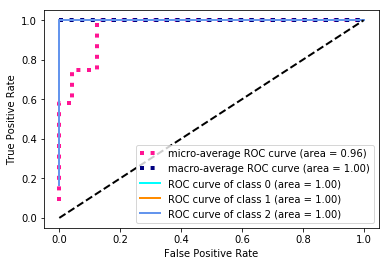

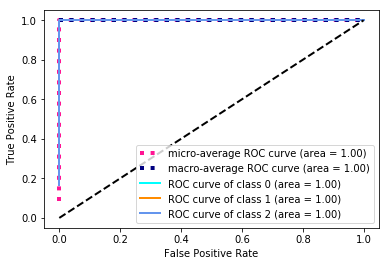

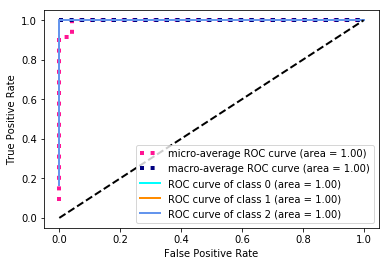

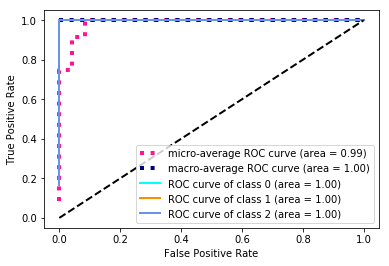

In [76]:
print('Accuarcy after PCA decomposition:')
classification_accuarcy(X_data_pca,Y_data,target_name=[task_contrasts[k] for k in np.arange(1,4)])
print('Accuarcy after Kernel PCA decomposition:')
classification_accuarcy(X_data_kpca,Y_data,target_name=[task_contrasts[k] for k in np.arange(1,4)])
print('Accuarcy after MDS decomposition:')
classification_accuarcy(X_data_mds,Y_data,target_name=[task_contrasts[k] for k in np.arange(1,4)])
print('Accuarcy after ICA decomposition:')
classification_accuarcy(X_data_ica,Y_data,target_name=[task_contrasts[k] for k in np.arange(1,4)])





In [79]:
###fMRI decoding: using event signals instead of activation pattern from glm
##collect task-fMRI signals
from pathlib import Path
pathroot=Path('/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/')
subject = 'sub01'
modality = 'motor'

pathdata = pathroot/subject/modality
print(pathdata)

import glob
fmri_files = [];
confound_files = [];
EVS_files = [];
for file in sorted(pathdata.glob('sess*/run*/filtered_func_data_ICA.nii.gz')):
    fmri_files.append(str(file))

for confound in sorted(pathdata.glob('sess*/run*/filtered_func_data_mcf.1D')):
    confound_files.append(str(confound))

for ev in sorted(pathdata.glob('sess*/run*/motor_events.txt')):
    EVS_files.append(str(ev))
    
print(fmri_files)
print(confound_files)
print(EVS_files)

/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor
['/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess01/run1/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess01/run2/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess02/run1/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess02/run2/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess03/run1/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess03/run2/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess04/run1/filtered_func_data_ICA.nii.gz', '/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/sub01/motor/sess04/run2/filtered_func_data_ICA.nii.gz', '/data/ci

In [81]:
##loading fMRI signals using atlas
from nilearn.image import mean_img
from nilearn.input_data import NiftiMasker
from nilearn.input_data import NiftiLabelsMasker
TR = 2.2
mist_atlas_file = "/data/cisl/raw_data/midnight/Rawdata/nii_data/preproc_fsl/MIST_ROI_3mm.nii.gz"

subjects_tc_matrix = [];
for fmri_file,confound_file in zip(fmri_files,confound_files):
    #fmri_file = fmri_files[0]
    #confound_file = confound_files[0]
    brain_masker = NiftiMasker(mask_strategy='epi')
    brain_masker.fit_transform(fmri_file)
    mean_fmri = mean_img(fmri_file)
    ##adjust group atlas to individual brain mask
    mist_atlas = NiftiLabelsMasker(labels_img=mist_atlas_file,mask_img=brain_masker.mask_img_,
                                  detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=TR)
    mist_roi_tc = mist_atlas.fit_transform(fmri_file,confounds=confound_file)
    subjects_tc_matrix.append(mist_roi_tc)

print(np.array(subjects_tc_matrix).shape)

(20, 104, 210)


In [140]:
###loading task information for each trial
import pandas as pd
trial_infos = pd.read_csv(EVS_files[0], sep="\t",encoding="utf8")
print(trial_infos.keys())

##trial info in volume instead of seconds
Onsets = np.ceil((trial_infos.onset/TR)).astype(int) #(trial_infos.onset/TR).astype(int)
Duras = np.ceil((trial_infos.duration/TR)).astype(int) #(trial_infos.duration/TR).astype(int)
Movetypes = trial_infos.trial_type

###create a label for each fMRI volume
task_contrasts = {"RFoot": "foot",
                  "LFoot": "foot",
                  "RHand": "hand",
                  "LHand": "hand",
                  "Tongue": "tongue",}

Trial_Num = len(subjects_tc_matrix[0])
Trial_labels = ["rest" for i in range(Trial_Num) ]#["rest"]*Trial_Num;
print(Trial_labels)
for start,dur,move in zip(Onsets,Duras,Movetypes):
    for ti in range(start-1,start+dur):
        Trial_labels[ti]= task_contrasts[move]
print(len(Trial_labels))

Index(['onset', 'duration', 'trial_type'], dtype='object')
['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest']
104


In [143]:
###combining multiple sessions together
import pandas as pd
Subject_Num = len(subjects_tc_matrix)
Trial_Num = len(subjects_tc_matrix[0])
print("Data samples including %d subjects with %d trials for each" % (Subject_Num, Trial_Num))

###dict for different types of movement
task_contrasts = {"RFoot": "foot",
                  "LFoot": "foot",
                  "RHand": "hand",
                  "LHand": "hand",
                  "Tongue": "tongue"}

subjects_trial_label_matrix = []
for subj in np.arange(Subject_Num):
    ##trial info in volume
    trial_infos = pd.read_csv(EVS_files[0], sep="\t",encoding="utf8")
    Onsets = np.ceil((trial_infos.onset/TR)).astype(int) #(trial_infos.onset/TR).astype(int)
    Duras = np.ceil((trial_infos.duration/TR)).astype(int) #(trial_infos.duration/TR).astype(int)
    Movetypes = trial_infos.trial_type
    
    labels = ["rest"]*Trial_Num;
    for start,dur,move in zip(Onsets,Duras,Movetypes):
        for ti in range(start-1,start+dur):
            labels[ti]= task_contrasts[move]
    subjects_trial_label_matrix.append(labels)

print(np.array(subjects_tc_matrix).shape)
print(np.array(subjects_trial_label_matrix).shape)

Data samples including 20 subjects with 104 trials for each
(20, 104, 210)
(20, 104)


In [199]:
####a simple classifier: X: activation within each region: feature: 210, samples: subjects*sessions*runs*trials
###                     Y: type of movement: foot,hand,tongue

##feature matrix
fmri_data = np.vstack(subjects_tc_matrix)
label_data = np.vstack(subjects_trial_label_matrix).reshape(Subject_Num*Trial_Num,)
print(fmri_data.shape,label_data.shape)

condition_mask = pd.Series(label_data).isin(np.unique(list(task_contrasts.values())))
X_data = fmri_data[condition_mask,]
Y_data = label_data[condition_mask]

##build a simple classifier using SVM
from sklearn import svm,metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
X_data_scaled = preprocessing.scale(X_data)
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_data_scaled,Y_data)
acc_score = metrics.accuracy_score(clf.predict(X_data_scaled),Y_data)
print("Accuracy of prediction: %4f" % acc_score)
print(clf.support_vectors_.shape)
print(clf.n_support_ )


##testing different dimensional reduction methods
my_cv_fold = 10
NComponent_new = [10,20,50,100,150]

clf = svm.SVC(decision_function_shape='ovo')
scores = cross_val_score(clf, X_data_scaled, Y_data, cv=my_cv_fold,scoring='accuracy')
print('SVM Scoring:')
#print(scores)
print('Mean Accuarcy %4f with std %4f ' % (np.mean(scores),np.std(scores)))
print('')

for comp in NComponent_new:
    print("Reduction into %d components" % comp)
    ##using pca for dimension reduction
    from sklearn.decomposition import PCA,FastICA,FactorAnalysis,DictionaryLearning,KernelPCA
    pca = PCA(n_components=comp, svd_solver='randomized',whiten=True)
    pca.fit(X_data_scaled)
    X_data_pca = pca.fit_transform(X_data_scaled)
    scores_pca = cross_val_score(clf, X_data_pca, Y_data, cv=my_cv_fold,scoring='accuracy')
    print('SVM Scoring after PCA decomposition: ')
    #print(scores_pca)
    print('Mean Accuarcy %4f with std %4f ' % (np.mean(scores_pca),np.std(scores_pca)))

    ##using fastica for dimension reduction
    ica = FastICA(n_components=comp, whiten=True)
    ica.fit(X_data_scaled)
    X_data_ica = ica.fit_transform(X_data_scaled)
    scores_ica = cross_val_score(clf, X_data_ica, Y_data, cv=my_cv_fold,scoring='accuracy')
    print('SVM Scoring after ICA decomposition: ')
    #print(scores_ica)
    print('Mean Accuarcy %4f with std %4f ' % (np.mean(scores_ica),np.std(scores_ica)))

    ##using kernelPCA for dimension reduction
    kpca = KernelPCA(n_components=comp, kernel='rbf')
    kpca.fit(X_data_scaled)
    X_data_kpca = kpca.fit_transform(X_data_scaled)
    scores_kpca = cross_val_score(clf, X_data_kpca, Y_data, cv=my_cv_fold,scoring='accuracy')
    print('SVM Scoring after Kernal PCA decomposition: ')
    #print(scores_kpca)
    print('Mean Accuarcy %4f with std %4f ' % (np.mean(scores_kpca),np.std(scores_kpca)))

    ##using MDS for dimension reduction
    from sklearn.manifold import MDS
    mds = MDS(n_components=comp, dissimilarity='euclidean', random_state=10)
    mds.fit(X_data_scaled)
    X_data_mds = mds.fit_transform(X_data_scaled)
    scores_mds = cross_val_score(clf, X_data_mds, Y_data, cv=my_cv_fold,scoring='accuracy')
    print('SVM Scoring after MDS decomposition: ')
    #print(scores_mds)
    print('Mean Accuarcy %4f with std %4f ' % (np.mean(scores_mds),np.std(scores_mds)))
    
    from sklearn.feature_selection import SelectPercentile, f_classif
    from sklearn.pipeline import Pipeline
    feature_selection = SelectPercentile(f_classif, percentile=comp*100./RegionsNum)
    anova_svc = Pipeline([('anova', feature_selection), ('svc', clf)])
    scores_anova = cross_val_score(anova_svc, X_data_scaled, Y_data, cv=my_cv_fold,scoring='accuracy')
    print('SVM Scoring after ANOVA feature selection based on F-test: ')
    #print(scores_anova)
    print('Mean Accuarcy %4f with std %4f ' % (scores_anova.mean(),scores_anova.std()))
    print('')
    print('')


(2080, 210) (2080,)
Accuracy of prediction: 0.916892
(1385, 210)
[567 518 300]
SVM Scoring:
Mean Accuarcy 0.431081 with std 0.036361 

Reduction into 10 components
SVM Scoring after PCA decomposition: 
Mean Accuarcy 0.441216 with std 0.062517 
SVM Scoring after ICA decomposition: 
Mean Accuarcy 0.418919 with std 0.000000 
SVM Scoring after Kernal PCA decomposition: 
Mean Accuarcy 0.466892 with std 0.044456 
SVM Scoring after MDS decomposition: 
Mean Accuarcy 0.415541 with std 0.004533 


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151

SVM Scoring after ANOVA feature selection based on F-test: 
Mean Accuarcy 0.438514 with std 0.022501 


Reduction into 20 components
SVM Scoring after PCA decomposition: 
Mean Accuarcy 0.431081 with std 0.048329 
SVM Scoring after ICA decomposition: 
Mean Accuarcy 0.418919 with std 0.000000 
SVM Scoring after Kernal PCA decomposition: 
Mean Accuarcy 0.479054 with std 0.022501 
SVM Scoring after MDS decomposition: 
Mean Accuarcy 0.414865 with std 0.006193 


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151

SVM Scoring after ANOVA feature selection based on F-test: 
Mean Accuarcy 0.433108 with std 0.041371 


Reduction into 50 components
SVM Scoring after PCA decomposition: 
Mean Accuarcy 0.433108 with std 0.037916 
SVM Scoring after ICA decomposition: 
Mean Accuarcy 0.418919 with std 0.000000 
SVM Scoring after Kernal PCA decomposition: 
Mean Accuarcy 0.418919 with std 0.000000 
SVM Scoring after MDS decomposition: 
Mean Accuarcy 0.452027 with std 0.043522 


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151

SVM Scoring after ANOVA feature selection based on F-test: 
Mean Accuarcy 0.439189 with std 0.046812 


Reduction into 100 components
SVM Scoring after PCA decomposition: 
Mean Accuarcy 0.417568 with std 0.028794 
SVM Scoring after ICA decomposition: 
Mean Accuarcy 0.418919 with std 0.000000 
SVM Scoring after Kernal PCA decomposition: 
Mean Accuarcy 0.418919 with std 0.000000 
SVM Scoring after MDS decomposition: 
Mean Accuarcy 0.443919 with std 0.059907 


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151

SVM Scoring after ANOVA feature selection based on F-test: 
Mean Accuarcy 0.444595 with std 0.036486 


Reduction into 150 components
SVM Scoring after PCA decomposition: 
Mean Accuarcy 0.416216 with std 0.038956 
SVM Scoring after ICA decomposition: 
Mean Accuarcy 0.418919 with std 0.000000 
SVM Scoring after Kernal PCA decomposition: 
Mean Accuarcy 0.418919 with std 0.000000 
SVM Scoring after MDS decomposition: 
Mean Accuarcy 0.453378 with std 0.051053 


/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151 152 154 206] are constant.
  UserWarning)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 19  23 114 115 129 151

SVM Scoring after ANOVA feature selection based on F-test: 
Mean Accuarcy 0.444595 with std 0.036736 




['foot' 'hand' 'tongue']
1480 samples with 210 dim features
Accuarcy after PCA decomposition:
Accuarcy on test data: 0.547297 and f1-score 0.529138
             precision    recall  f1-score   support

       foot       0.48      0.63      0.54       112
       hand       0.66      0.53      0.59       130
     tongue       0.51      0.41      0.45        54

avg / total       0.57      0.55      0.55       296

Confusion Matrix:
[[71 26 15]
 [55 69  6]
 [23  9 22]]
Accuarcy after Kernel PCA decomposition:
Accuarcy on test data: 0.581081 and f1-score 0.488773
             precision    recall  f1-score   support

       foot       0.52      0.76      0.62       112
       hand       0.67      0.62      0.64       130
     tongue       0.50      0.13      0.21        54

avg / total       0.58      0.58      0.55       296

Confusion Matrix:
[[85 23  4]
 [47 80  3]
 [30 17  7]]
Accuarcy after MDS decomposition:
Accuarcy on test data: 0.466216 and f1-score 0.413973
             precision 

/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/mnt/home_sq/yzhang/python_venv/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuarcy on test data: 0.408784 and f1-score 0.230300
             precision    recall  f1-score   support

       foot       0.39      1.00      0.56       112
       hand       1.00      0.07      0.13       130
     tongue       0.00      0.00      0.00        54

avg / total       0.59      0.41      0.27       296

Confusion Matrix:
[[112   0   0]
 [121   9   0]
 [ 54   0   0]]


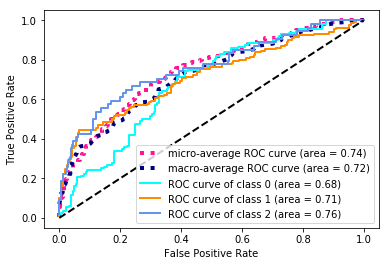

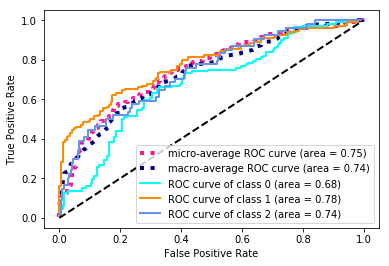

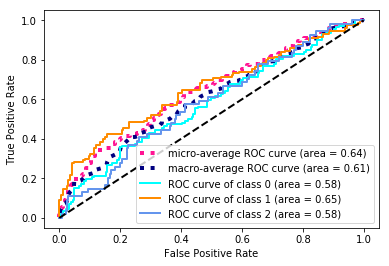

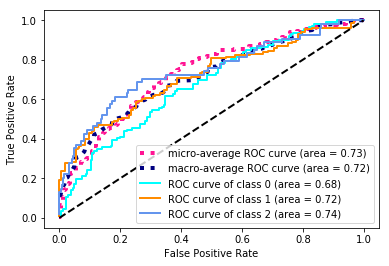

In [201]:
print(np.unique(list(task_contrasts.values())))
print('%d samples with %d dim features' % (X_data.shape[0],X_data.shape[1]))
print('Accuarcy after PCA decomposition:')
classification_accuarcy(X_data_pca,Y_data,target_name=np.unique(list(task_contrasts.values())))
print('Accuarcy after Kernel PCA decomposition:')
classification_accuarcy(X_data_kpca,Y_data,target_name=np.unique(list(task_contrasts.values())))
print('Accuarcy after MDS decomposition:')
classification_accuarcy(X_data_mds,Y_data,target_name=np.unique(list(task_contrasts.values())))
print('Accuarcy after ICA decomposition:')
classification_accuarcy(X_data_ica,Y_data,target_name=np.unique(list(task_contrasts.values())))


Accuracy of prediction: 0.819595
(971, 210)
[414 335 222]
(61, 73, 61, 3)


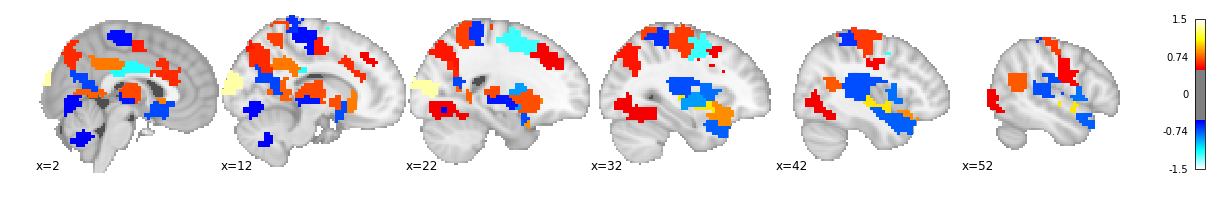

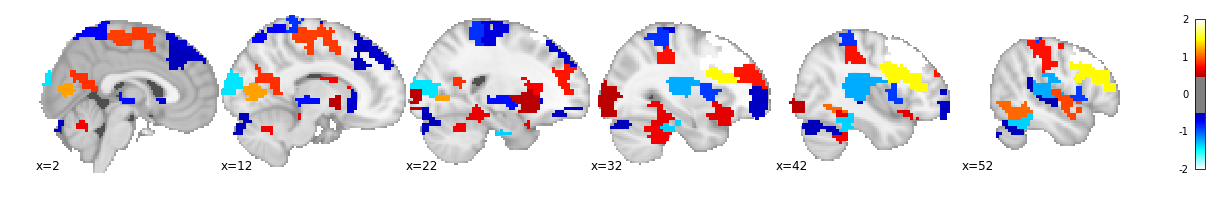

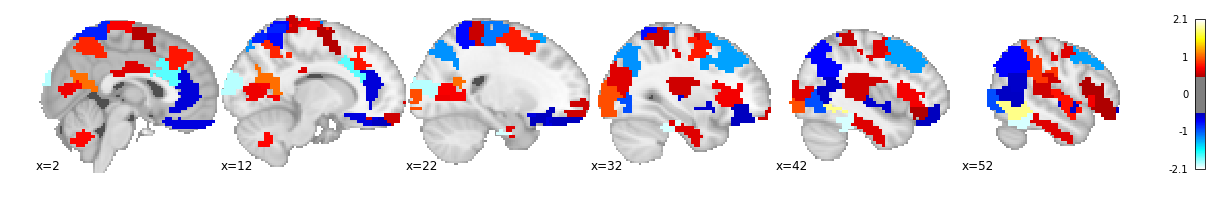

In [202]:

clf_lin = svm.SVC(decision_function_shape='ovr',kernel='linear')
clf_lin.fit(X_data_scaled,Y_data)
acc_score = metrics.accuracy_score(clf_lin.predict(X_data_scaled),Y_data)
print("Accuracy of prediction: %4f" % acc_score)
print(clf_lin.support_vectors_.shape)
print(clf_lin.n_support_ )

mist_atlas = NiftiLabelsMasker(labels_img=mist_atlas_file,detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=TR)
mist_atlas.fit_transform(fmri_file,confounds=confound_file)
roi_coefs = clf_lin.coef_
svc_coef_img = mist_atlas.inverse_transform(roi_coefs)
print(svc_coef_img.shape)
svc_coef_img.to_filename('fmri_decoding_motor_svc_weights.nii.gz')

from nilearn import plotting,image
for img in image.iter_img(svc_coef_img):
    plotting.plot_stat_map(img,display_mode="x",cut_coords=range(2, 53, 10),threshold=0.5)

In [194]:
print(svc_coef_img.shape)

(61, 73, 61, 3)
